In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # força a usar só CPU

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs visíveis:", tf.config.list_physical_devices('GPU'))


2025-11-15 18:41:09.561961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-15 18:41:09.589927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-15 18:41:10.501232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 18:41:20.685463: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

TF: 2.20.0
GPUs visíveis: []


2025-11-15 18:41:30.286339: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
import zipfile

zip_path = "/content/trashnet.zip"
extract_path = "/content/trashnet"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extraído em:", extract_path)


Extraído em: /content/trashnet


In [ ]:
import pydot
print("Pydot version:", pydot.__version__)
import shutil
print("Graphviz no PATH:", shutil.which("dot"))



Pydot version: 3.0.4
Graphviz no PATH: /usr/bin/dot


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

In [ ]:
!pip install -q datasets
from datasets import load_dataset
import os
import shutil
from tqdm import tqdm

# Carrega o dataset do HuggingFace (só precisa rodar 1 vez)
dataset = load_dataset("garythung/trashnet", split="train")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from pathlib import Path
import pandas as pd

data_path = Path("/content/trashnet/trashnet")
print("Classes encontradas:", [d.name for d in data_path.iterdir() if d.is_dir()])


Classes encontradas: ['trash', 'cardboard', 'glass', 'metal', 'plastic', 'paper']


In [ ]:
from pathlib import Path
import pandas as pd

data_path = Path("/content/trashnet/trashnet")
print("Classes encontradas:", [d.name for d in data_path.iterdir() if d.is_dir()])

data = []
for folder in data_path.iterdir():
    if folder.is_dir():
        file_count = len(list(folder.glob("*")))
        data.append({"Folder Name": folder.name, "File Count": file_count})

count = pd.DataFrame(data).set_index("Folder Name")
count


Classes encontradas: ['trash', 'cardboard', 'glass', 'metal', 'plastic', 'paper']


,File Count
Folder Name,
trash,137
cardboard,403
glass,501
metal,410
plastic,482
paper,594


In [ ]:
print(f'Total {count.sum()}')

Total File Count    2527
dtype: int64


In [ ]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

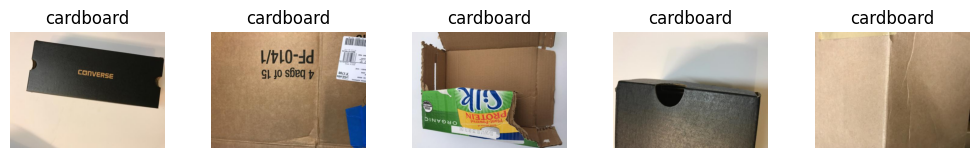

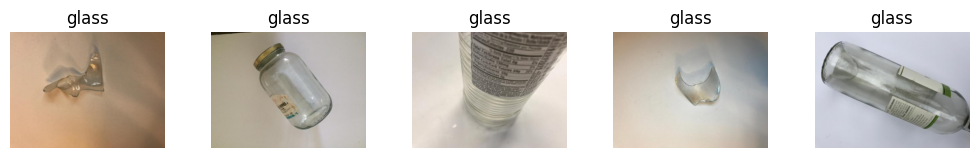

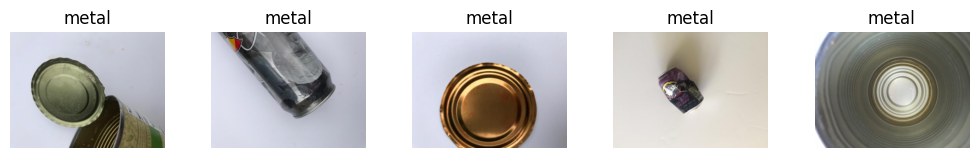

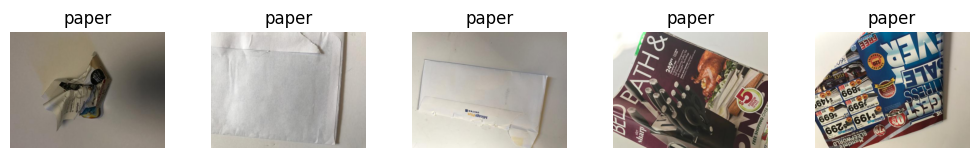

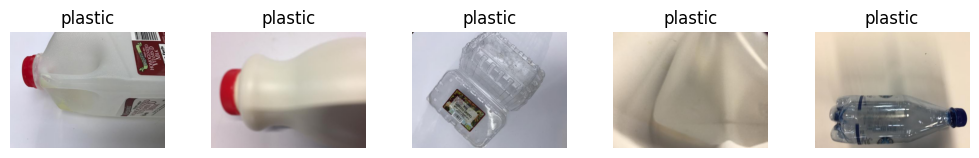

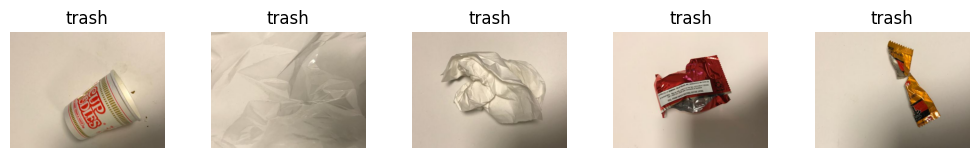

In [ ]:
plot_imgs(data_path / 'cardboard')
plot_imgs(data_path / 'glass')
plot_imgs(data_path / 'metal')
plot_imgs(data_path / 'paper')
plot_imgs(data_path / 'plastic')
plot_imgs(data_path / 'trash')


In [ ]:
# Define variable for requirements
batch_size = 30
target_size = (96, 96)

validation_split = 0.15

In [ ]:
train_img_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_data_img_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)


In [ ]:
train_data = train_img_generator.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True,
    seed=42
)

test_data = test_data_img_generator.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.


In [ ]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


In [ ]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
import sys
print("Python do notebook:", sys.executable)

# instala pydot e graphviz usando ESTE Python
!{sys.executable} -m pip install pydot graphviz

import pydot
print("Pydot carregado de:", pydot.__file__)


Python do notebook: /usr/bin/python3
Pydot carregado de: /usr/local/lib/python3.12/dist-packages/pydot/__init__.py


In [ ]:
import shutil
print("dot no sistema:", shutil.which("dot"))


dot no sistema: /usr/bin/dot


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 98, 98, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,740,422 (6.64 MB)

 Trainable params: 1,740,422 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [ ]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
print("Classes e índices:", train_data.class_indices)
print("Número de classes:", train_data.num_classes)


Classes e índices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Número de classes: 6


In [ ]:
epochs = 20  # ou outro valor razoável

history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    callbacks=[ES, RLROP, MCH]
)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - categorical_accuracy: 0.2292 - loss: 1.7770

72/72 ━━━━━━━━━━━━━━━━━━━━ 70s 851ms/step - categorical_accuracy: 0.2297 - loss: 1.7758 - val_categorical_accuracy: 0.2812 - val_loss: 1.6381 - learning_rate: 0.0010
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - categorical_accuracy: 0.3441 - loss: 1.5551

72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 781ms/step - categorical_accuracy: 0.3442 - loss: 1.5550 - val_categorical_accuracy: 0.3289 - val_loss: 1.6082 - learning_rate: 0.0010
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - categorical_accuracy: 0.3766 - loss: 1.4679

72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 756ms/step - categorical_accuracy: 0.3766 - loss: 1.4680 - val_categorical_accuracy: 0.3740 - val_loss: 1.5848 - learning_rate: 0.0010
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - categorical_accuracy: 0.4277 - loss: 1.4225

72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 767ms/step - categorical_accuracy: 0.4274 - loss: 1.4228 - val_categorical_accuracy: 0.3554 - val_loss: 1.5296 - learning_rate: 0.0010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - categorical_accuracy: 0.4117 - loss: 1.4246

72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 745ms/step - categorical_accuracy: 0.4119 - loss: 1.4244 - val_categorical_accuracy: 0.4164 - val_loss: 1.5211 - learning_rate: 0.0010
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 981ms/step - categorical_accuracy: 0.4584 - loss: 1.3230 - val_categorical_accuracy: 0.3846 - val_loss: 1.5350 - learning_rate: 0.0010
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - categorical_accuracy: 0.4915 - loss: 1.3103

72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - categorical_accuracy: 0.4916 - loss: 1.3103 - val_categorical_accuracy: 0.3926 - val_loss: 1.4906 - learning_rate: 0.0010
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - categorical_accuracy: 0.4642 - loss: 1.3224

72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 763ms/step - categorical_accuracy: 0.4645 - loss: 1.3223 - val_categorical_accuracy: 0.4218 - val_loss: 1.4562 - learning_rate: 0.0010
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 741ms/step - categorical_accuracy: 0.5119 - loss: 1.2504 - val_categorical_accuracy: 0.3820 - val_loss: 1.5061 - learning_rate: 0.0010
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - categorical_accuracy: 0.4981 - loss: 1.2894

72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 758ms/step - categorical_accuracy: 0.4981 - loss: 1.2893 - val_categorical_accuracy: 0.4775 - val_loss: 1.4056 - learning_rate: 0.0010
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 739ms/step - categorical_accuracy: 0.5313 - loss: 1.2262 - val_categorical_accuracy: 0.4615 - val_loss: 1.4804 - learning_rate: 0.0010
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 741ms/step - categorical_accuracy: 0.4637 - loss: 1.3229 - val_categorical_accuracy: 0.4721 - val_loss: 1.4467 - learning_rate: 0.0010
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 759ms/step - categorical_accuracy: 0.5529 - loss: 1.1743 - val_categorical_accuracy: 0.4615 - val_loss: 1.4450 - learning_rate: 0.0010
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 780ms/step - categorical_accuracy: 0.5270 - loss: 1.1967 - val_categorical_accuracy: 0.4456 - val_loss: 1.4239 - learning_rate: 0.0010
Epoch 15/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 778ms/step - categorical_accuracy: 0.5574 - loss: 1.1579 - val_categorical_accu

72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 814ms/step - categorical_accuracy: 0.5504 - loss: 1.1588 - val_categorical_accuracy: 0.4695 - val_loss: 1.3957 - learning_rate: 0.0010
Epoch 18/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - categorical_accuracy: 0.5498 - loss: 1.1687

72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 834ms/step - categorical_accuracy: 0.5499 - loss: 1.1686 - val_categorical_accuracy: 0.4668 - val_loss: 1.3903 - learning_rate: 0.0010
Epoch 19/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - categorical_accuracy: 0.5988 - loss: 1.0862

72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 779ms/step - categorical_accuracy: 0.5985 - loss: 1.0867 - val_categorical_accuracy: 0.5199 - val_loss: 1.3601 - learning_rate: 0.0010
Epoch 20/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 837ms/step - categorical_accuracy: 0.5638 - loss: 1.1136 - val_categorical_accuracy: 0.5066 - val_loss: 1.3831 - learning_rate: 0.0010


In [ ]:
# Avaliação final no conjunto de validação (test_data)
loss, acc = model.evaluate(test_data)
print(f"Loss de validação: {loss:.4f}")
print(f"Acurácia de validação: {acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - categorical_accuracy: 0.4969 - loss: 1.3861
Loss de validação: 1.3831
Acurácia de validação: 0.5066


In [ ]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.5198938846588135


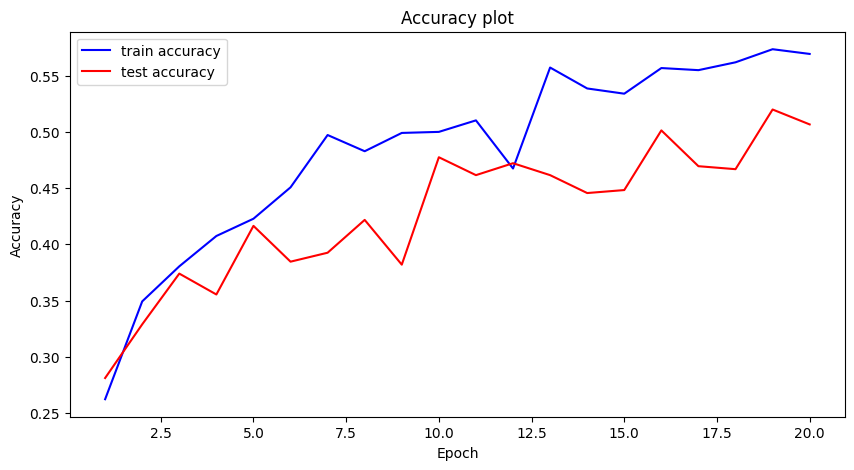

In [ ]:
# Accuracy on train data :
accuracy = history.history['categorical_accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [ ]:
import os

folder = "/content/trashnet/trashnet/paper"
print(os.listdir(folder)[:20])  # mostra os 20 primeiros


['paper417.jpg', 'paper433.jpg', 'paper87.jpg', 'paper345.jpg', 'paper108.jpg', 'paper304.jpg', 'paper276.jpg', 'paper4.jpg', 'paper498.jpg', 'paper268.jpg', 'paper541.jpg', 'paper10.jpg', 'paper492.jpg', 'paper549.jpg', 'paper355.jpg', 'paper111.jpg', 'paper274.jpg', 'paper311.jpg', 'paper343.jpg', 'paper452.jpg']


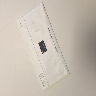

In [ ]:
from tensorflow.keras.preprocessing import image as utils

img_path = "/content/trashnet/trashnet/paper/paper11.jpg"

img = utils.load_img(
    img_path,
    color_mode='rgb',
    target_size=target_size,   # <<< o mesmo usado no treino
    interpolation='nearest'
)

img


In [ ]:
# === Célula: preparar a imagem e prever a classe ===
import numpy as np
import tensorflow as tf

img_array = utils.img_to_array(img)      # (96, 96, 3)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)  # (1, 96, 96, 3)

pred = model.predict(img_array)

# inverter o dicionário {classe: índice} -> {índice: classe}
idx_to_class = {v: k for k, v in train_data.class_indices.items()}

pred_class_idx = np.argmax(pred, axis=1)[0]
print("Classe prevista:", idx_to_class[pred_class_idx])
print("Distribuição de probabilidade:", pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Classe prevista: glass
Distribuição de probabilidade: [0.05688261 0.29357612 0.135815   0.20555341 0.10937813 0.19879471]


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


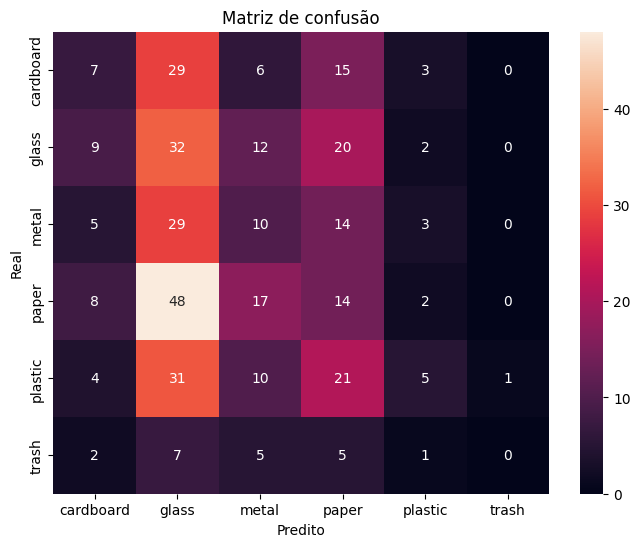

              precision    recall  f1-score   support

   cardboard       0.20      0.12      0.15        60
       glass       0.18      0.43      0.25        75
       metal       0.17      0.16      0.17        61
       paper       0.16      0.16      0.16        89
     plastic       0.31      0.07      0.11        72
       trash       0.00      0.00      0.00        20

    accuracy                           0.18       377
   macro avg       0.17      0.16      0.14       377
weighted avg       0.19      0.18      0.16       377



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Garante que o generator não embaralha
test_data.shuffle = False

y_true = test_data.classes
y_pred_proba = model.predict(test_data)
y_pred = np.argmax(y_pred_proba, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = list(test_data.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de confusão")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))
